In [2]:
# ECG Signal Classification using a Custom CNN (Apnea Detection)
#
# This notebook tests a custom 1D CNN on ECG signal data. It performs the following:
# 1. Loads and normalizes training and test ECG signals.
# 2. Splits the data into training and validation sets.
# 3. Defines a custom 1D CNN architecture for binary classification.
# 4. Trains the model using Ignite with progress bars, early stopping, and learning rate scheduling.
# 5. Evaluates the model on a test set and computes various metrics.
# 6. Optimizes decision thresholds using ROC and Precision-Recall curves.
#
# Note: Update file paths as needed.

In [3]:
import os
import glob
import gc
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as patches

import torch
import torch.nn as nn
import torch.optim as optim
import torch.optim.lr_scheduler as lr_scheduler
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

import torchvision.transforms as transforms
import torchvision.transforms.v2 as v2
from torchvision import models

from sklearn.metrics import (accuracy_score, classification_report, confusion_matrix, 
                             hamming_loss, ConfusionMatrixDisplay, 
                             precision_score, recall_score, f1_score, roc_curve, auc)
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, GridSearchCV
from sklearn.feature_selection import SelectKBest, f_classif

import neurokit2 as nk

from imblearn.over_sampling import SMOTE
from xgboost import XGBClassifier

# Ignite imports for training loop management
from ignite.engine import Engine, Events, create_supervised_trainer, create_supervised_evaluator
from ignite.handlers import EarlyStopping, ModelCheckpoint, TerminateOnNan
from ignite.contrib.handlers import ProgressBar
from ignite.metrics import Loss, Accuracy, Precision, Recall

from tqdm.notebook import tqdm

import warnings
warnings.filterwarnings("ignore")


In [4]:
# Data Loading and Normalization (Raw data can be generated from the raw_data_generating jupyter notebook)
# Load training ECG signals and labels (assumes numpy arrays are saved at these paths)
ECG_signal_train = np.load(r"C:\Users\piotr\Downloads\training_signal.npy")
ECG_labels_train = np.load(r"C:\Users\piotr\Downloads\training labels.npy")

def z_score_normalization(ecg_signal):
    """Normalize an ECG signal using Z-score normalization."""
    mean = np.mean(ecg_signal)
    std = np.std(ecg_signal) + 1e-8  # Avoid division by zero
    return (ecg_signal - mean) / std

# Normalize each ECG signal in the training set
for i in range(len(ECG_signal_train)):
    ECG_signal_train[i] = z_score_normalization(ECG_signal_train[i])

# Split data into training and validation sets
data_train, data_val, label_train, label_val = train_test_split(ECG_signal_train, ECG_labels_train)


In [5]:
# Custom Dataset Definition
class My1DDataset(Dataset):
    def __init__(self, data, labels):
        if isinstance(data, np.ndarray):
            data = torch.tensor(data, dtype=torch.float32)
        if data.ndim == 2:
            data = data.unsqueeze(1)  # Add channel dimension
        self.data = data.to(device) if device else data
        self.labels = torch.tensor(labels, dtype=torch.float32).view(-1, 1)
        if device:
            self.labels = self.labels.to(device)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx], self.labels[idx]

In [6]:
# CNN Model Definition
class CNNBlock(nn.Module):
    """
    A basic 1D CNN block: Conv1d -> BatchNorm1d -> ReLU -> MaxPool1d -> Dropout.
    """
    def __init__(self, in_channels, out_channels, kernel_size=32):
        super(CNNBlock, self).__init__()
        self.conv = nn.Conv1d(in_channels, out_channels, kernel_size=kernel_size, padding='same')
        self.bn = nn.BatchNorm1d(out_channels)
        self.pool = nn.MaxPool1d(kernel_size=2, stride=2)
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        x = F.relu(self.bn(self.conv(x))) 
        x = self.pool(x) 
        x = self.dropout(x)  
        return x
class ApneaCNN(nn.Module):
    """
    CNN model for apnea detection on ECG signals.
    Architecture: 10 CNN blocks followed by fully connected layers.
    """
    def __init__(self, input_channels=1, input_length=12000):
        super(ApneaCNN, self).__init__()

        # Feature Extraction: 10 CNN layers
        self.conv_layers = nn.Sequential(
            CNNBlock(input_channels, 45),
            CNNBlock(45, 45),
            CNNBlock(45, 45),
            CNNBlock(45, 45),
            CNNBlock(45, 45),
            CNNBlock(45, 45),
            CNNBlock(45, 45),
            CNNBlock(45, 45),
            CNNBlock(45, 45),
            CNNBlock(45, 45)
        )


        # Fully Connected Layers
        self.fc_layers = nn.Sequential(
            nn.Flatten(),
            nn.Linear(11*45, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Dropout(0.5),

            nn.Linear(512, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Dropout(0.5),

            nn.Linear(512, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Dropout(0.5),

            nn.Linear(512, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Dropout(0.5),

            nn.Linear(512, 1),  # Output: Binary classification
        )

    def forward(self, x):
        x = self.conv_layers(x)
        x = self.fc_layers(x)
        return x

In [7]:
# Setup Training Environment
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = ApneaCNN().to(device)

# Define loss function and optimizer
criterion = nn.BCEWithLogitsLoss().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=3)

# Create datasets and dataloaders for training and validation
train_dataset = My1DDataset(data_train, label_train)
val_dataset = My1DDataset(data_val, label_val)
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=0)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False, num_workers=0)

In [8]:
# Create a supervised trainer using Ignite
trainer = create_supervised_trainer(model, optimizer, criterion, device=device)

# Function to threshold outputs for evaluation (sigmoid then round)
def thresholded_output_transform(output):
    y_pred, y = output
    y_pred = torch.round(torch.sigmoid(y_pred))
    return y_pred, y

# Define evaluation metrics
val_metrics = {
    "accuracy": Accuracy(output_transform=thresholded_output_transform),
    "precision": Precision(output_transform=thresholded_output_transform),
    "recall": Recall(output_transform=thresholded_output_transform),
    "loss": Loss(criterion)
}

train_evaluator = create_supervised_evaluator(model, metrics=val_metrics, device=device)
val_evaluator = create_supervised_evaluator(model, metrics=val_metrics, device=device)

# Attach a progress bar
pbar = ProgressBar(persist=True)
pbar.attach(trainer, output_transform=lambda x: {"loss": x})


In [9]:
# Ignite Event Handlers

@trainer.on(Events.EPOCH_COMPLETED)
def run_validation(engine):
    val_evaluator.run(val_loader)
    metrics = val_evaluator.state.metrics
    avg_accuracy = metrics['accuracy']
    avg_loss = metrics['loss']
    print(f"\nValidation - Epoch: {engine.state.epoch} | "
          f"Avg accuracy: {avg_accuracy:.4f} | Avg loss: {avg_loss:.4f}")
@trainer.on(Events.EPOCH_COMPLETED)
def log_learning_rate(engine):
    current_lr = optimizer.param_groups[0]['lr']
    print(f"Learning Rate after Epoch {engine.state.epoch}: {current_lr:.6f}")
@trainer.on(Events.EPOCH_COMPLETED)
def run_scheduler(engine):
    val_loss = val_evaluator.state.metrics["loss"]
    scheduler.step(val_loss)
    print(f"Scheduler stepped with validation loss: {val_loss:.4f}")
    
early_stopping = EarlyStopping(
    patience=10,  # Number of epochs to wait without improvement
    score_function=lambda engine: -engine.state.metrics["loss"],  # Use validation loss (negative for minimizing)
    trainer=trainer
)
val_evaluator.add_event_handler(Events.COMPLETED, early_stopping)
trainer.add_event_handler(Events.ITERATION_COMPLETED, TerminateOnNan())

checkpoint_handler = ModelCheckpoint(
    dirname='checkpoints',
    filename_prefix='chestxray',
    n_saved=1,
    create_dir=True,
    require_empty=False,
    score_function=lambda e: -e.state.metrics["loss"], 
    score_name="val_loss",
    global_step_transform=lambda e, _: e.state.epoch
)

val_evaluator.add_event_handler(Events.COMPLETED, checkpoint_handler, {
    'best_model': model
})

In [11]:
# Run training for a maximum of 1000 epochs. The early stopping will kick in around 37 epochs. 
# trainer.run(train_loader, max_epochs=1000)
# Alternatively simply load the included checkpoint:
model.load_state_dict(torch.load(r"checkpoints\chestxray_best_model_1_val_loss=-0.1384.pt"))

# 

<All keys matched successfully>

In [12]:
# Load test data
ECG_signal_test = np.load(r"C:\Users\piotr\Downloads\test_signal.npy")
ECG_labels_test = np.load(r"C:\Users\piotr\Downloads\test labels.npy")
for i in range(len(ECG_signal_test)):
    ECG_signal_test[i] = z_score_normalization(ECG_signal_test[i])
    
test_dataset = My1DDataset(ECG_signal_test, ECG_labels_test)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

# Evaluate the model on the test set and store outputs
logits = []
labels_list = []

def evaluate_step(engine, batch):
    model.eval()
    with torch.no_grad():
        images, label = batch
        images = images.to(device)
        label = label.to(device)
        outputs = model(images)
        logits.append(outputs.cpu().numpy())
        labels_list.append(label.cpu().numpy())
    return outputs, label

evaluator = Engine(evaluate_step)
evaluator.run(test_loader)

# Concatenate results from test evaluation
logits_array = np.concatenate(logits, axis=0)
labels_array = np.concatenate(labels_list, axis=0)

# Convert logits to probabilities using sigmoid
probs = torch.sigmoid(torch.tensor(logits_array)).numpy()
preds = (probs > 0.5).astype(int)
y_true = labels_array.astype(int)
y_pred = preds.astype(int)

# Print classification report
print("\nClassification Report (Per-Class):")
print(classification_report(y_true, y_pred))


Classification Report (Per-Class):
              precision    recall  f1-score   support

           0       0.87      0.96      0.91     10363
           1       0.91      0.75      0.83      6273

    accuracy                           0.88     16636
   macro avg       0.89      0.86      0.87     16636
weighted avg       0.88      0.88      0.88     16636



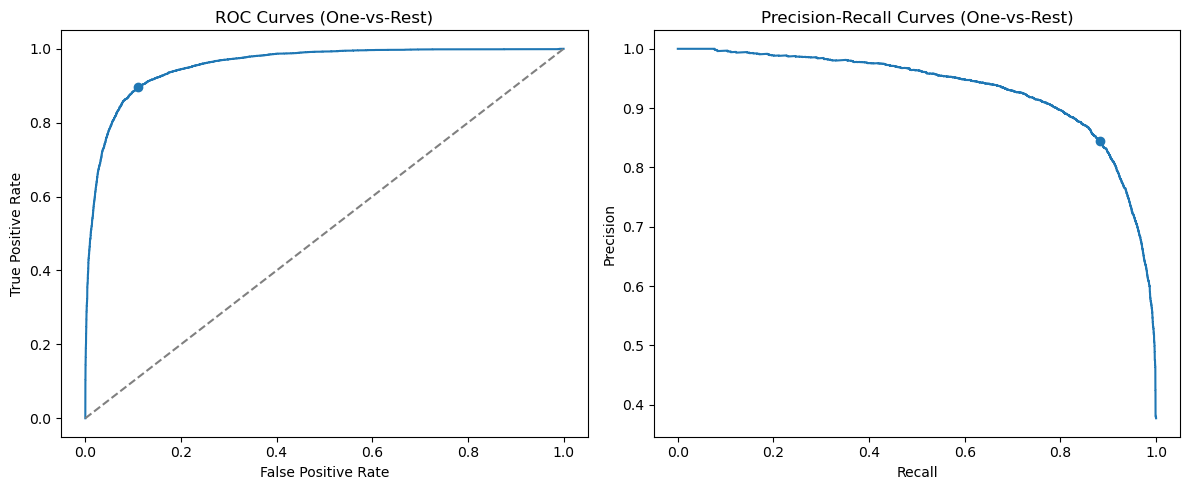


Classification Report (Thresholds from ROC):
              precision    recall  f1-score   support

           0       0.93      0.89      0.91     10363
           1       0.83      0.90      0.86      6273

    accuracy                           0.89     16636
   macro avg       0.88      0.89      0.89     16636
weighted avg       0.90      0.89      0.89     16636


Classification Report (Thresholds from PR Curve):
              precision    recall  f1-score   support

           0       0.93      0.90      0.91     10363
           1       0.84      0.88      0.86      6273

    accuracy                           0.89     16636
   macro avg       0.89      0.89      0.89     16636
weighted avg       0.90      0.89      0.89     16636



In [13]:
import numpy as np
import torch
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, precision_recall_curve, auc, f1_score

# Compute probabilities (again, if needed) and set number of classes (binary case: 1)
probs = torch.sigmoid(torch.tensor(logits_array)).numpy()
num_classes = 1
optimal_thresholds_roc = np.zeros(num_classes)
optimal_thresholds_pr = np.zeros(num_classes)

plt.figure(figsize=(12, 5))

# For each class, compute ROC and Precision-Recall curves and find optimal thresholds
for class_idx in range(num_classes):
    class_labels = labels_array[:, class_idx]  # Binary labels
    fpr, tpr, roc_thresholds = roc_curve(class_labels, probs[:, class_idx])
    roc_auc = auc(fpr, tpr)
    
    # Youden’s J statistic to find optimal ROC threshold
    youden_j = tpr - fpr
    optimal_idx_roc = np.argmax(youden_j)
    optimal_thresholds_roc[class_idx] = roc_thresholds[optimal_idx_roc]
    
    precision, recall, pr_thresholds = precision_recall_curve(class_labels, probs[:, class_idx])
    pr_auc = auc(recall, precision)
    f1_scores = 2 * (precision * recall) / (precision + recall + 1e-8)
    optimal_idx_pr = np.argmax(f1_scores)
    optimal_thresholds_pr[class_idx] = pr_thresholds[optimal_idx_pr]
    
    # Plot ROC Curve
    plt.subplot(1, 2, 1)
    plt.plot(fpr, tpr, label=f'Class {class_idx} (AUC = {roc_auc:.2f})')
    plt.scatter(fpr[optimal_idx_roc], tpr[optimal_idx_roc], 
                label=f'Class {class_idx} Thresh = {optimal_thresholds_roc[class_idx]:.3f}')
    
    # Plot Precision-Recall Curve
    plt.subplot(1, 2, 2)
    plt.plot(recall, precision, label=f'Class {class_idx} (AUC = {pr_auc:.2f})')
    plt.scatter(recall[optimal_idx_pr], precision[optimal_idx_pr],
                label=f'Class {class_idx} Thresh = {optimal_thresholds_pr[class_idx]:.3f}')

# Format ROC plot
plt.subplot(1, 2, 1)
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves (One-vs-Rest)')

# Format Precision-Recall plot
plt.subplot(1, 2, 2)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curves (One-vs-Rest)')

plt.tight_layout()
plt.show()

# Apply ROC-based thresholds
preds = (probs > optimal_thresholds_roc).astype(int)
y_true = labels_array.astype(int)
y_pred = preds.astype(int)
print("\nClassification Report (Thresholds from ROC):")
print(classification_report(y_true, y_pred))

# Alternatively, apply PR-based thresholds
preds_pr = (probs > optimal_thresholds_pr).astype(int)
y_pred_pr = preds_pr.astype(int)
print("\nClassification Report (Thresholds from PR Curve):")
print(classification_report(y_true, y_pred_pr))